In [9]:
import math
import pandas as pd
import tqdm
import numpy as np
import pathlib

import torch
import torch.utils.data as data
import torch.optim as optim

from MINE import controller, datasets, losses, models

In [11]:
def experiment(target_value):
    data_loader = data.DataLoader(
        datasets.IntegerPairDataset(
            number_of_cases=16,
            x_encoding='one_hot',
            y_encoding='one_hot',
            transform=datasets.TransformToTensor()
        ),
        batch_size=100,
    )
    loss = losses.remine_loss(target_value=target_value, regularizer_weight=0.1)
    network = models.ConcatNet(16, 64)
    optimizer = optim.SGD(network.parameters(), lr=0.1)

    agent = controller.MINEController(
        data_loader=data_loader, loss=loss, network=network, optimizer=optimizer
    )
    
    agent_path = f'observing_different_target_{target_value}.pth'
    if pathlib.Path(agent_path).exists():
        print(f'Loading {agent_path}')
        agent.load(agent_path)
    else:
        agent.to(0)
        agent.train()
        for i in tqdm.tqdm(range(1500)):
            agent.step()
        agent.save(agent_path)

    return agent

In [12]:
cs = [-5, -2, 0, 2, 5]
histories = []
for c in cs:
    histories.append(experiment(c).history)

100%|██████████| 1500/1500 [00:22<00:00, 66.80it/s]


In [13]:
def get_t(history, batch_size=100):
    t = []
    for i in range(0, len(history), batch_size):
        t.append(np.average(history.joint_value[i:i+batch_size]))
    return np.array(t)

def get_et(history, batch_size=100):
    et = []
    for i in range(0, len(history), batch_size):
        et.append(np.log(np.average(np.exp(history.marginal_value[i:i+batch_size]))))
    return np.array(et)

['$\\log(\\mathbb{E}_{\\mathbb{P}_X \\otimes \\mathbb{P}_Y}[e^{T}])$', 'Estimated MI', '$\\mathbb{E}_{\\mathbb{P}_{X Y}}[T]$', 'True MI', '$C^*$'] ['$\\mathbb{E}_{\\mathbb{P}_{X Y}}[T]$', 'Estimated MI', '$\\log(\\mathbb{E}_{\\mathbb{P}_X \\otimes \\mathbb{P}_Y}[e^{T}])$', 'True MI', '$C^*$']


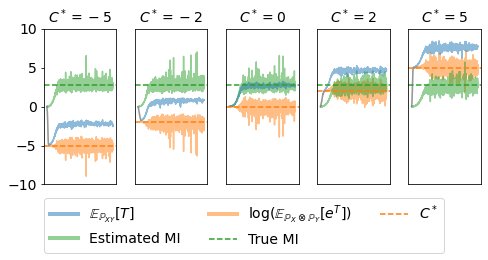

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(7, 3))
for i, c in enumerate(cs):
    plt.subplot(1, 5, i+1)

    t = get_t(histories[i])
    et = get_et(histories[i])
    mi = t-et

    plt.plot(et, alpha=0.5, label='$\log(\mathbb{E}_{\mathbb{P}_X \otimes \mathbb{P}_Y}[e^{T}])$' if i == 0 else None, c='C1')
    plt.plot(mi, alpha=0.5, label='Estimated MI' if i == 0 else None, c='C2')
    plt.plot(t, alpha=0.5, label='$\mathbb{E}_{\mathbb{P}_{X Y}}[T]$' if i == 0 else None, c='C0')
    plt.axhline(np.log(16), label='True MI' if i == 0 else None, color='C2', ls='--', alpha=1.0)
    plt.axhline(c, label='$C^*$' if i == 0 else None, color='C1', ls='--', alpha=1.0)
    plt.ylim(-10, 10)
    plt.title(f'$C^*={c}$', fontdict={'fontsize' : 14})

    plt.xticks([])
    if i != 0:
        plt.yticks([])
    else:
        plt.yticks(fontsize=14)

handles, labels = plt.gcf().axes[0].get_legend_handles_labels()
order = [2, 1, 0, 3, 4]
lg = plt.gcf().legend(
    [handles[idx] for idx in order], [labels[idx] for idx in order],
    ncol=3, loc='center', bbox_to_anchor=(0.5, -0.08)
)
plt.setp(lg.get_lines()[:3], linewidth=4)
plt.tight_layout()
# plt.gcf().subplots_adjust(down=0.75)

# plt.show()
plt.savefig('shifting_c.pdf', bbox_inches='tight')